In [1]:
import sys
sys.path.append('../../')

In [2]:
from codes.docs.analysis import data_preprocessing, MLtraining
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from collections import defaultdict

# Diffusion

In [3]:
european_diffusion_dataset_term=pd.read_csv('./preprocessed_data/diffusion/term/european_diffusion_dataset_term.csv')

In [4]:
feature_column_names=european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'].columns

Dividing the dataset into high and low risk using the PRS scores, thresholded at 0.05.

In [5]:
#preprocess the PRS score
PRS_thresholds=['PRS_1e08', 'PRS_1e07', 'PRS_1e06', 'PRS_1e05', 'PRS_0.0001','PRS_0.001', 'PRS_0.01', 'PRS_0.05', 'PRS_0.1', 'PRS_0.5', 'PRS_1']
# PRS_thresholds=['PRS_0.05']

adjusted_prs_score=data_preprocessing.adjusting_for_covariates_with_lin_reg(np.array(european_diffusion_dataset_term['PRS_0.05']),
np.array(european_diffusion_dataset_term['Anc_PC1']),np.array(european_diffusion_dataset_term['Anc_PC2']),np.array(european_diffusion_dataset_term['Anc_PC3']))

Train model on the bottom 40% (low risk) and perform PRS correlation on the top 20% (high risk)

In [6]:
high_risk,low_risk=data_preprocessing.high_low_risk_divide(adjusted_prs_score,high_perc=0.2,low_perc=0.4)
high_risk=high_risk[1:]
X_total=np.asarray(european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'])
X_low_risk=np.asarray(european_diffusion_dataset_term.loc[low_risk,'PreCG.R_PreCG.L':'ITG.R_ITG.L'])
X_high_risk=np.asarray(european_diffusion_dataset_term.loc[high_risk,'PreCG.R_PreCG.L':'ITG.R_ITG.L'])


y_total=np.asarray(european_diffusion_dataset_term['PMA_diff'])
y_low_risk=np.asarray(european_diffusion_dataset_term.loc[low_risk,'PMA_diff'])
y_high_risk=np.asarray(european_diffusion_dataset_term.loc[high_risk,'PMA_diff'])

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, Ridge, LassoCV, ElasticNetCV
from sklearn.model_selection import GridSearchCV,cross_validate
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
import time

In [8]:
covariates=np.asarray(european_diffusion_dataset_term[['GA_diff','PMA_diff','Gender']])
covariates_low_risk=np.concatenate((StandardScaler().fit_transform(covariates[low_risk,:2]),LabelBinarizer().fit_transform(covariates[low_risk,-1])),axis=1)

PRS_score_scaler=StandardScaler().fit(adjusted_prs_score[low_risk].reshape(-1,1))
adjusted_prs_score_scaled_low_risk=PRS_score_scaler.transform(adjusted_prs_score[low_risk].reshape(-1,1)).reshape(-1)

adjusted_prs_score_scaled_high_risk=PRS_score_scaler.transform(adjusted_prs_score[high_risk].reshape(-1,1)).reshape(-1)

In [28]:
#Perform Retain_non_zero_features, and correlated features to prs_score from the low_risk dataset
start=time.time()
pipe0=Pipeline([('remove_zeros',MLtraining.Retain_non_zero_features()),
('remove_correlation',MLtraining.High_Corr_Remover(target=adjusted_prs_score_scaled_low_risk,thresh=0.8,average=True,connected_components=True)),
('select_p_Val',MLtraining.Select_Features_Univariate(adjusted_prs_score_scaled_low_risk,covariates_low_risk))])

X_low_risk_after_pipe0=pipe0.fit_transform(X_low_risk)
X_high_risk_after_pipe0=pipe0.transform(X_high_risk)
print(time.time()-start)

1.5555939674377441


## Ridge

In [10]:
#### with RFECV

In [29]:
#Training the PMA prediction model on the transformed low_risk dataset
data_splitting=MLtraining.splitting_dataset_into_k_fold(X_low_risk_after_pipe0,y_low_risk,k=3)
result={}
y_high_risk_pred_dict={}
features_coefs_dict={}
inner_fold_feature_selection_logs=defaultdict(list)
for i in tqdm.tqdm(range(3)):
    X_trainval, y_trainval, X_test, y_test=next(data_splitting)
    inner_cv=KFold(n_splits=3)
    param_dict=[{'regr__alpha':np.linspace(0.1,100,100)}]
    regr=Ridge()
    pipe1=MLtraining.myPipe([('scaler', StandardScaler()),('regr',regr)])
    grid_search=GridSearchCV(pipe1,param_grid=param_dict,cv=inner_cv).fit(X_trainval,y_trainval)
    pipe1=grid_search.best_estimator_
    rfecv=RFECV(pipe1).fit(X_trainval,y_trainval)
    # sfs=SequentialFeatureSelector(pipe1,cv=inner_cv,direction='backward').fit(X_trainval,y_trainval)
    # pipe1.fit(sfs.transform(X_trainval),y_trainval)
    #normal
    # bias_coeff,bias_intercept=MLtraining.get_model_bias(y_trainval,pipe1.predict(X_trainval))
    # y_pred=pipe1.predict(X_test)#model performance on low risk
    # y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    # result[i]=MLtraining.print_scores(y_pred,y_test)
    # features_coefs_dict[i]=pipe1.named_steps['regr'].coef_
    # with RFECV
    bias_coeff,bias_intercept=MLtraining.get_model_bias(y_trainval,rfecv.predict(X_trainval))
    y_pred=rfecv.predict(X_test)#model performance on low risk
    y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    result[i]=MLtraining.print_scores(y_pred,y_test)
    features_coefs_dict[i]=pipe1.named_steps['regr'].coef_
    #with SFS
    # bias_coeff,bias_intercept=MLtraining.get_model_bias(y_trainval,pipe1.predict(sfs.transform(X_trainval)))
    # y_pred=pipe1.predict(sfs.transform(X_test))#model performance on low risk
    # y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    # result[i]=MLtraining.print_scores(y_pred,y_test)
    # features_coefs_dict[i]=pipe1.named_steps['regr'].coef_
    #with RFECV
    inner_fold_feature_selection_logs[i].extend(rfecv.get_support())
    #use the trained model to predict the brain age (PMA at scan) for high risk subject
    y_high_risk_pred=rfecv.predict(X_high_risk_after_pipe0)
    y_high_risk_pred=y_high_risk_pred+y_high_risk_pred*bias_coeff+bias_intercept
    y_high_risk_pred_dict[i]=y_high_risk_pred
    #with SFS
    # inner_fold_feature_selection_logs[i].extend(sfs.get_support())
    # #use the trained model to predict the brain age (PMA at scan) for high risk subject
    # y_high_risk_pred=pipe1.predict(sfs.transform(X_high_risk_after_pipe0))
    # y_high_risk_pred=y_high_risk_pred+y_high_risk_pred*bias_coeff+bias_intercept
    # y_high_risk_pred_dict[i]=y_high_risk_pred

100%|██████████| 3/3 [00:08<00:00,  2.98s/it]


In [30]:
PMA_result=pd.DataFrame(result).T
PMA_result=PMA_result.append(pd.DataFrame(PMA_result.mean(axis=0)).T,ignore_index=True)
PMA_result.rename(index={0:'0',1:'1',2:'2',3:'Average'})

,r2,MAE,RMSE,Correlation,p_value
0,0.440944,0.906143,1.128722,0.754683,0.000077
1,0.515118,1.020109,1.213856,0.756575,0.000113
2,0.516621,0.780422,1.070930,0.724241,0.000305
Average,0.490895,0.902225,1.137836,0.745167,0.000165


Text(0.5, 1.0, 'testing y_pred_bias vs y_true')

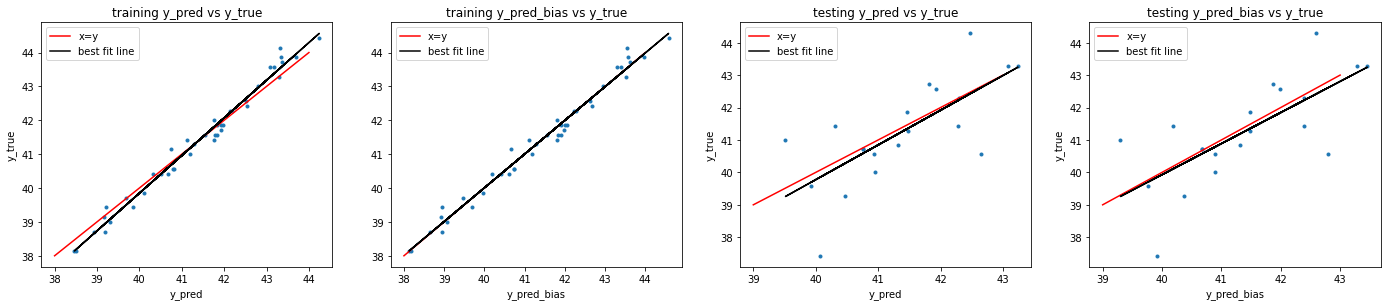

In [31]:
y_train_pred=rfecv.predict(X_trainval)
f,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4.5))
ax1.plot(y_train_pred,y_trainval,'.')
ax1.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred.reshape(-1,1),y_trainval)
ax1.plot(y_train_pred,lin_reg.predict(y_train_pred.reshape(-1,1)),'k-',label='best fit line')
ax1.set_ylabel('y_true')
ax1.set_xlabel('y_pred')
ax1.legend()
ax1.set_title('training y_pred vs y_true')

y_pred=rfecv.predict(X_test)
ax3.plot(y_pred,y_test,'.')
ax3.plot([39,43],[39,43],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred.reshape(-1,1),y_test)
ax3.plot(y_pred,lin_reg.predict(y_pred.reshape(-1,1)),'k-',label='best fit line')
ax3.set_ylabel('y_true')
ax3.set_xlabel('y_pred')
ax3.legend()
ax3.set_title('testing y_pred vs y_true')


lin_reg_bias=LinearRegression()
coef,inter=MLtraining.get_model_bias(y_trainval,y_train_pred)
y_train_pred_bias=y_train_pred+y_train_pred*coef+inter
ax2.plot(y_train_pred_bias,y_trainval,'.')
ax2.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred_bias.reshape(-1,1),y_trainval)
ax2.plot(y_train_pred_bias,lin_reg.predict(y_train_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax2.set_xlabel('y_pred_bias')
ax2.legend()
ax2.set_title('training y_pred_bias vs y_true')

y_pred_bias=y_pred+y_pred*coef+inter
ax4.plot(y_pred_bias,y_test,'.')
ax4.plot([39,43],[39,43],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred_bias.reshape(-1,1),y_test)
ax4.plot(y_pred_bias,lin_reg.predict(y_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax4.set_ylabel('y_true')
ax4.set_xlabel('y_pred_bias')
ax4.legend()
ax4.set_title('testing y_pred_bias vs y_true')



In [32]:
brain_age_difference=pd.DataFrame(y_high_risk_pred_dict)
brain_age_difference['mean_PMA_pred']=brain_age_difference.mean(axis=1)
brain_age_difference['true_PMA']=y_high_risk
brain_age_difference['residual']=brain_age_difference['mean_PMA_pred']-brain_age_difference['true_PMA']

brain_age_difference

,0,1,2,mean_PMA_pred,true_PMA,residual
0,42.799463,43.230291,42.297567,42.775773,44.714286,-1.938512
1,42.414008,42.597507,42.505171,42.505562,43.571429,-1.065867
2,40.011881,40.491193,39.974890,40.159321,41.000000,-0.840679
3,40.381565,40.463856,40.420096,40.421839,42.714286,-2.292447
4,40.235064,41.078403,41.547725,40.953731,42.285714,-1.331984
5,41.490902,42.833419,41.884465,42.069595,44.000000,-1.930405
6,41.774034,41.090266,42.123048,41.662450,42.000000,-0.337550
7,42.523774,42.301120,42.761357,42.528750,42.142857,0.385893
8,43.385205,42.760349,42.388732,42.844762,44.285714,-1.440952
9,41.635874,41.532462,42.031504,41.733280,42.000000,-0.266720


In [33]:
brain_age_difference_corr=pd.DataFrame({'Correlation':(pearsonr(brain_age_difference['residual'],adjusted_prs_score_scaled_high_risk))[0],
'p-value':(pearsonr(brain_age_difference['residual'],adjusted_prs_score_scaled_high_risk))[1]},index=['PRS_0.05'])

brain_age_difference_corr

,Correlation,p-value
PRS_0.05,-0.601909,0.000433


Text(0, 0.5, 'brain age difference')

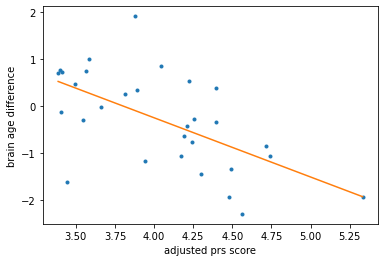

In [34]:
plt.plot(adjusted_prs_score_scaled_high_risk,brain_age_difference['residual'],'.')
lin_reg=LinearRegression()
lin_reg.fit(adjusted_prs_score_scaled_high_risk.reshape(-1,1),brain_age_difference['residual'].values)
plt.plot(adjusted_prs_score_scaled_high_risk,lin_reg.predict(adjusted_prs_score_scaled_high_risk.reshape(-1,1)))
plt.xlabel('adjusted prs score')
plt.ylabel('brain age difference')

### Checking features


In [17]:
original_ROIs_combinations=european_diffusion_dataset_term.loc[low_risk,'PreCG.R_PreCG.L':'ITG.R_ITG.L'].columns
pipe0.named_steps['remove_zeros'].get_column_names(original_ROIs_combinations)
ROIs_combination_remove_zeros=pipe0.named_steps['remove_zeros'].reduced_features_names
print(ROIs_combination_remove_zeros.shape)
pipe0.named_steps['remove_correlation'].get_column_names(ROIs_combination_remove_zeros)
ROIs_combination_remove_correlation=pipe0.named_steps['remove_correlation'].reduced_features_names
print(ROIs_combination_remove_correlation.shape)
pipe0.named_steps['select_p_Val'].get_column_names(ROIs_combination_remove_correlation)
ROIs_combination_select_univariate=pipe0.named_steps['select_p_Val'].reduced_features_names
print(ROIs_combination_select_univariate.shape)

(2612,)
(2265,)
(175,)


In [18]:
coefs_of_prs_pval=pipe0.named_steps['select_p_Val'].coefficients[pipe0.named_steps['select_p_Val'].p_value<0.05]

In [19]:
inner_folds_selection=pd.DataFrame(inner_fold_feature_selection_logs)
inner_folds_selection=inner_folds_selection[(inner_folds_selection[0]==True)&(inner_folds_selection[1]==True)&(inner_folds_selection[2]==True)]

In [20]:
ROIs_coef=pd.DataFrame(zip(ROIs_combination_select_univariate,coefs_of_prs_pval,features_coefs_dict[0],features_coefs_dict[1],features_coefs_dict[2]),columns=['Connection','PRS_coefs','PMA_Coef_split_1','PMA_Coef_split_2','PMA_Coef_split_3'])
ROIs_coef['PMA_Mean_Coef']=ROIs_coef[['PMA_Coef_split_1','PMA_Coef_split_2','PMA_Coef_split_3']].mean(axis=1)
# ROIs_coef_RidgeCV=ROIs_coef.reindex(ROIs_coef['Mean_Coef'].abs().sort_values(ascending=False).index)
ROIs_coef=ROIs_coef.iloc[inner_folds_selection.index,:]

In [21]:
ROIs_coef['PRS*PMA_coefs']=ROIs_coef['PRS_coefs']*ROIs_coef['PMA_Mean_Coef']

In [22]:
ROIs_coef_RidgeCV=ROIs_coef.reindex(ROIs_coef['PRS*PMA_coefs'].abs().sort_values(ascending=False).index)

In [23]:
merged_feature_dict_strings=pipe0.named_steps['remove_correlation'].merged_feature_dict_strings
ROIs_coef_RidgeCV['Merged_Feature']=[False if not merged_feature_dict_strings[i] else True for i in ROIs_coef_RidgeCV['Connection']]

In [24]:
ROIs_coef_RidgeCV.head(10)

,Connection,PRS_coefs,PMA_Coef_split_1,PMA_Coef_split_2,PMA_Coef_split_3,PMA_Mean_Coef,PRS*PMA_coefs,Merged_Feature
120,PUT.L_CAU.L,-0.297101,0.079055,0.065872,0.071787,0.072238,-0.021462,False
117,PUT.L_REC.L,-0.402210,0.059788,0.041412,0.058048,0.053082,-0.021350,False
70,IPL.L_REC.L,-0.421774,-0.055757,-0.011988,-0.071998,-0.046581,0.019647,False
83,PreCUN.L_ROL.L,-0.300068,-0.080794,-0.047321,-0.065516,-0.064544,0.019367,False
12,ORBinf.R_IFGtriang.R,-0.281637,0.055965,0.064218,0.083880,0.068021,-0.019157,False
44,AMYG.R_ORBsumed.R,0.323221,0.071844,0.027964,0.075293,0.058367,0.018865,False
174,ITG.R_FFG.R,-0.286553,0.090738,0.054619,0.049347,0.064901,-0.018598,False
135,PAL.R_MOG.R,0.278513,0.047019,0.070148,0.073584,0.063584,0.017709,False
123,PUT.R_ORBinf.R,-0.353645,0.045727,0.058598,0.042885,0.049070,-0.017353,False
78,ANG.L_SPG.L,-0.401399,0.023398,0.050284,0.052834,0.042172,-0.016928,False


## Random Forrest

In [20]:
#Training the PMA prediction model on the low_risk dataset
data_splitting=MLtraining.splitting_dataset_into_k_fold(X_low_risk_after_pipe0,y_low_risk,k=3)
result={}
y_high_risk_pred_dict={}
features_coefs_dict={}
for i in tqdm.tqdm(range(3)):
    X_trainval, y_trainval, X_test, y_test=next(data_splitting)
    inner_cv=KFold(n_splits=3)
    # regr=RidgeCV(cv=inner_cv)#find the best_hyperparameter
    # regr=RandomForestRegressor(bootstrap=True,oob_score=False,random_state=42)
    regr=LinearSVR(loss='squared_epsilon_insensitive')
    # param_dict=[{'regr__n_estimators':[250,300],'regr__max_depth':[250]}]
    param_dict=[{'regr__C':np.linspace(0,10,100)}]
    pipe1=Pipeline([('scaler', StandardScaler()),('regr',regr)])
    search=GridSearchCV(pipe1,param_grid=param_dict,cv=inner_cv).fit(X_trainval,y_trainval).fit(X_trainval,y_trainval)
    pipe1=search.best_estimator_
    print(pipe1)
    # pipe1.fit(X_trainval,y_trainval)

    bias_coeff,bias_intercept=MLtraining.get_model_bias(y_trainval,pipe1.predict(X_trainval))
    y_pred=pipe1.predict(X_test)#model performance on low risk
    y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    result[i]=MLtraining.print_scores(y_pred,y_test)
    # features_coefs_dict[i]=pipe1.named_steps['regr'].feature_importances_

    #use the trained model to predict the brain age (PMA at scan) for high risk subject
    y_high_risk_pred=pipe1.predict(X_high_risk_after_pipe0)
    y_high_risk_pred=y_high_risk_pred+y_high_risk_pred*bias_coeff+bias_intercept
    y_high_risk_pred_dict[i]=y_high_risk_pred

rn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/hai/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/hai/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_classes.py", line 425, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Users/hai/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py", line 975, in _fit_liblinear
    raw_coef_, n_iter_ = liblinear.train_wrap(
  File "sklearn/svm/_liblinear.pyx", line 52, in sklearn.svm._liblinear.train_wrap
ValueError: b'C <= 0'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/hai/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters wi

Text(0.5, 1.0, 'testing y_pred_bias vs y_true')

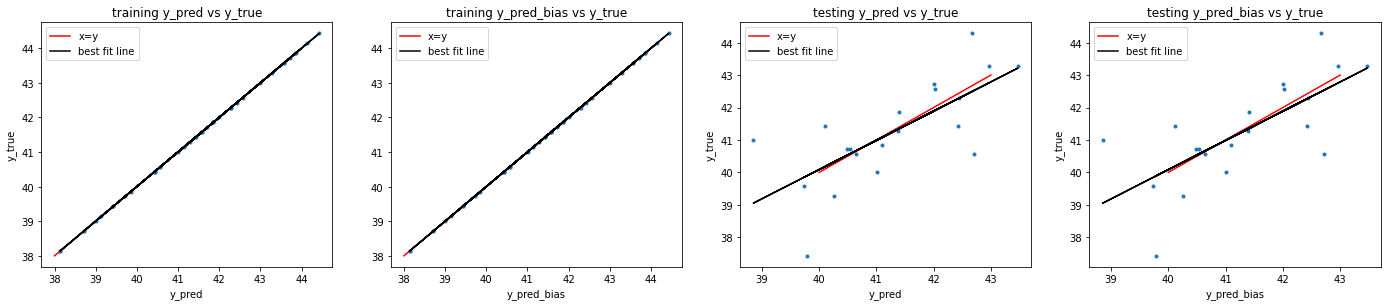

In [18]:
y_train_pred=pipe1.predict(X_trainval)
f,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4.5))
ax1.plot(y_train_pred,y_trainval,'.')
ax1.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred.reshape(-1,1),y_trainval)
ax1.plot(y_train_pred,lin_reg.predict(y_train_pred.reshape(-1,1)),'k-',label='best fit line')
ax1.set_ylabel('y_true')
ax1.set_xlabel('y_pred')
ax1.legend()
ax1.set_title('training y_pred vs y_true')

y_pred=pipe1.predict(X_test)
ax3.plot(y_pred,y_test,'.')
ax3.plot([40,43],[40,43],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred.reshape(-1,1),y_test)
ax3.plot(y_pred,lin_reg.predict(y_pred.reshape(-1,1)),'k-',label='best fit line')
ax3.set_ylabel('y_true')
ax3.set_xlabel('y_pred')
ax3.legend()
ax3.set_title('testing y_pred vs y_true')


lin_reg_bias=LinearRegression()
coef,inter=MLtraining.get_model_bias(y_trainval,y_train_pred)
y_train_pred_bias=y_train_pred+y_train_pred*coef+inter
ax2.plot(y_train_pred_bias,y_trainval,'.')
ax2.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred_bias.reshape(-1,1),y_trainval)
ax2.plot(y_train_pred_bias,lin_reg.predict(y_train_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax2.set_xlabel('y_pred_bias')
ax2.legend()
ax2.set_title('training y_pred_bias vs y_true')

y_pred_bias=y_pred+y_pred*coef+inter
ax4.plot(y_pred_bias,y_test,'.')
ax4.plot([40,43],[40,43],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred_bias.reshape(-1,1),y_test)
ax4.plot(y_pred_bias,lin_reg.predict(y_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax4.set_ylabel('y_true')
ax4.set_xlabel('y_pred_bias')
ax4.legend()
ax4.set_title('testing y_pred_bias vs y_true')



In [21]:
PMA_result=pd.DataFrame(result).T
PMA_result=PMA_result.append(pd.DataFrame(PMA_result.mean(axis=0)).T,ignore_index=True)
PMA_result.rename(index={0:'0',1:'1',2:'2',3:'Average'})

,r2,MAE,MSE,Correlation,p_value
0,0.150071,1.099399,1.936874,0.626478,0.002376
1,0.440223,1.046200,1.701037,0.687138,0.000817
2,0.506312,0.795542,1.171350,0.716360,0.000381
Average,0.365535,0.980380,1.603087,0.676659,0.001191


In [22]:
brain_age_difference=pd.DataFrame(y_high_risk_pred_dict)
brain_age_difference['mean_PMA_pred']=brain_age_difference.mean(axis=1)
brain_age_difference['true_PMA']=y_high_risk
brain_age_difference['residual']=brain_age_difference['mean_PMA_pred']-brain_age_difference['true_PMA']

In [24]:
brain_age_difference_corr=pd.DataFrame({'Correlation':(pearsonr(brain_age_difference['residual'],adjusted_prs_score[high_risk[1:]]))[0],
'p-value':(pearsonr(brain_age_difference['residual'],adjusted_prs_score[high_risk[1:]]))[1]},index=['PRS_0.05'])

brain_age_difference_corr

,Correlation,p-value
PRS_0.05,-0.557176,0.001382


Text(0, 0.5, 'brain age difference')

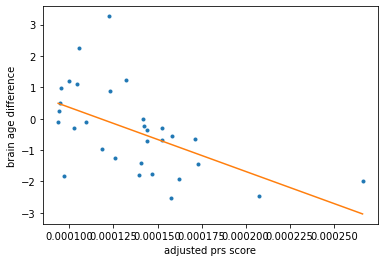

In [25]:
plt.plot(adjusted_prs_score[high_risk],brain_age_difference['residual'],'.')
lin_reg=LinearRegression()
lin_reg.fit(adjusted_prs_score[high_risk].reshape(-1,1),brain_age_difference['residual'].values)
plt.plot(adjusted_prs_score[high_risk],lin_reg.predict(adjusted_prs_score[high_risk].reshape(-1,1)))
plt.xlabel('adjusted prs score')
plt.ylabel('brain age difference')

### Checking features

In [26]:
#Checking features
original_ROIs_combinations=european_diffusion_dataset_term.loc[low_risk,'PreCG.R_PreCG.L':'ITG.R_ITG.L'].columns
pipe0.named_steps['remove_zeros'].get_column_names(original_ROIs_combinations)
ROIs_combination_remove_zeros=pipe0.named_steps['remove_zeros'].reduced_features_names
print(ROIs_combination_remove_zeros.shape)
pipe0.named_steps['remove_correlation'].get_column_names(ROIs_combination_remove_zeros)
ROIs_combination_remove_correlation=pipe0.named_steps['remove_correlation'].reduced_features_names
print(ROIs_combination_remove_correlation.shape)
pipe0.named_steps['select_p_Val'].get_column_names(ROIs_combination_remove_correlation)
ROIs_combination_select_univariate=pipe0.named_steps['select_p_Val'].reduced_features_names
print(ROIs_combination_select_univariate.shape)

(2612,)
(2306,)
(178,)


In [27]:
ROIs_coef=pd.DataFrame(zip(ROIs_combination_select_univariate,features_coefs_dict[0],features_coefs_dict[1],features_coefs_dict[2]),columns=['Connection','Coef_split_1','Coef_split_2','Coef_split_3'])
ROIs_coef['Mean_Coef']=ROIs_coef[['Coef_split_1','Coef_split_2','Coef_split_3']].mean(axis=1)
ROIs_coef_RF=ROIs_coef.sort_values('Mean_Coef',ascending=False)

In [28]:
combined_best_ROIs_coef_table=ROIs_coef_RidgeCV.head(10).merge(ROIs_coef_RF.head(10),on='Connection',how='outer',suffixes=('_RidgeCV','_RF'),indicator=True)
combined_best_ROIs_coef_table=combined_best_ROIs_coef_table.drop(combined_best_ROIs_coef_table.columns[[1,2,3,5,6,7]],axis=1)

combined_best_ROIs_coef_table['Merged_Feature']=[False if not merged_feature_dict_strings[i] else True for i in combined_best_ROIs_coef_table['Connection']]

In [29]:
combined_best_ROIs_coef_table.rename(columns={'_merge':'duplicated'})

,Connection,Mean_Coef_RidgeCV,Mean_Coef_RF,duplicated,Merged_Feature
0,PUT.L_CAU.L,0.075683,0.023322,both,False
1,REC.R_ORBsumed.R,0.073661,0.039708,both,False
2,ORBinf.R_IFGtriang.R,0.071776,0.094992,both,False
3,PreCUN.L_ROL.L,-0.066633,NaN,left_only,False
4,ITG.R_FFG.R,0.066441,0.075478,both,False
5,PAL.R_MOG.R,0.066036,NaN,left_only,False
6,DCG.L_ACG.L,0.064818,0.026969,both,False
7,AMYG.R_ORBsumed.R,0.064313,NaN,left_only,False
8,THA.R_ORBmid.L,-0.062156,0.020553,both,False
9,SMG.R_REC.R,-0.058083,NaN,left_only,False


In [30]:
merged_feature_dict_strings_diff=merged_feature_dict_strings

In [31]:
merged_feature_dict_strings_diff['SMG.R_ORBmid.R']

['SMG.R_ORBmid.R', 'PoCG.R_ORBmid.R']

# Volumetric

In [150]:
european_diffusion_dataset_term=pd.read_csv('./preprocessed_data/diffusion/term/european_diffusion_dataset_term.csv')

In [151]:
feature_names_volumetric=european_diffusion_dataset_term.loc[:,"'1 Precentral_L 2001'":"'93 Vermis'"]

In [152]:
#preprocess the PRS score
PRS_thresholds=['PRS_1e08', 'PRS_1e07', 'PRS_1e06', 'PRS_1e05', 'PRS_0.0001','PRS_0.001', 'PRS_0.01', 'PRS_0.05', 'PRS_0.1', 'PRS_0.5', 'PRS_1']
# PRS_thresholds=['PRS_0.05']

adjusted_prs_score=data_preprocessing.adjusting_for_covariates_with_lin_reg(np.array(european_diffusion_dataset_term['PRS_0.05']),
np.array(european_diffusion_dataset_term['Anc_PC1']),np.array(european_diffusion_dataset_term['Anc_PC2']),np.array(european_diffusion_dataset_term['Anc_PC3']))

In [153]:
high_risk,low_risk=data_preprocessing.high_low_risk_divide(adjusted_prs_score,high_perc=0.2,low_perc=0.4)
high_risk=high_risk[2:]
X_total=np.asarray(european_diffusion_dataset_term.loc[:,"'1 Precentral_L 2001'":"'93 Vermis'"])
X_low_risk=np.asarray(european_diffusion_dataset_term.loc[low_risk,"'1 Precentral_L 2001'":"'93 Vermis'"])
X_high_risk=np.asarray(european_diffusion_dataset_term.loc[high_risk,"'1 Precentral_L 2001'":"'93 Vermis'"])


y_total=np.asarray(european_diffusion_dataset_term['PMA_struc'])
y_low_risk=np.asarray(european_diffusion_dataset_term.loc[low_risk,'PMA_struc'])
y_high_risk=np.asarray(european_diffusion_dataset_term.loc[high_risk,'PMA_struc'])

In [154]:
covariates=np.asarray(european_diffusion_dataset_term[['17 ICV (all except bone)','GA_struc','PMA_struc','Gender']])

covariates_low_risk=np.concatenate((StandardScaler().fit_transform(covariates[low_risk,:2]),LabelBinarizer().fit_transform(covariates[low_risk,-1])),axis=1)

PRS_score_scaler=StandardScaler().fit(adjusted_prs_score[low_risk].reshape(-1,1))
adjusted_prs_score_scaled_low_risk=PRS_score_scaler.transform(adjusted_prs_score[low_risk].reshape(-1,1)).reshape(-1)

adjusted_prs_score_scaled_high_risk=PRS_score_scaler.transform(adjusted_prs_score[high_risk].reshape(-1,1)).reshape(-1)

In [155]:
#Perform Retain_non_zero_features, and correlated features to prs_score from the low_risk dataset
start=time.time()
# pipe0=Pipeline([('remove_zeros',MLtraining.Retain_non_zero_features()),
# ('remove_correlation',MLtraining.High_Corr_Remover(target=adjusted_prs_score_scaled_low_risk,thresh=0.8,average=True,connected_components=True)),
# ('select_p_Val',MLtraining.Select_Features_Univariate(adjusted_prs_score[low_risk],covariates[low_risk,:]))])
# pipe0=Pipeline([('remove_zeros',MLtraining.Retain_non_zero_features()),
# ('remove_correlation',MLtraining.High_Corr_Remover(target=adjusted_prs_score_scaled_low_risk,thresh=0.8,average=True,connected_components=True))])
pipe0=Pipeline([('remove_zeros',MLtraining.Retain_non_zero_features())])
X_low_risk_after_pipe0=pipe0.fit_transform(X_low_risk)
X_high_risk_after_pipe0=pipe0.transform(X_high_risk)
print(time.time()-start)

0.0034759044647216797


## Ridge

In [156]:
#Training the PMA prediction model on the transformed low_risk dataset
data_splitting=MLtraining.splitting_dataset_into_k_fold(X_low_risk_after_pipe0,y_low_risk,k=3)
result={}
y_high_risk_pred_dict={}
features_coefs_dict={}
inner_fold_feature_selection_logs=defaultdict(list)
for i in tqdm.tqdm(range(3)):
    X_trainval, y_trainval, X_test, y_test=next(data_splitting)
    inner_cv=KFold(n_splits=3)
    param_dict=[{'regr__alpha':np.linspace(0.1,100,100)}]
    regr=Ridge()
    # regr=LinearSVR()
    # param_dict=[{'regr__C':np.linspace(0.1,10,100)}]
    pipe1=MLtraining.myPipe([('scaler', StandardScaler()),('regr',regr)])
    grid_search=GridSearchCV(pipe1,param_grid=param_dict,cv=inner_cv).fit(X_trainval,y_trainval)
    pipe1=grid_search.best_estimator_
    rfecv=RFECV(pipe1,cv=inner_cv).fit(X_trainval,y_trainval)

    #normal
    # bias_coeff,bias_intercept=MLtraining.get_model_bias(y_trainval,pipe1.predict(X_trainval))
    # y_pred=pipe1.predict(X_test)#model performance on low risk
    # y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    # result[i]=MLtraining.print_scores(y_pred,y_test)
    # features_coefs_dict[i]=pipe1.named_steps['regr'].coef_
    # with RFECV
    bias_coeff,bias_intercept=MLtraining.get_model_bias(y_trainval,rfecv.predict(X_trainval))
    y_pred=rfecv.predict(X_test)#model performance on low risk
    y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    result[i]=MLtraining.print_scores(y_pred,y_test)
    features_coefs_dict[i]=pipe1.named_steps['regr'].coef_

    #with normal
    # y_high_risk_pred=pipe1.predict(X_high_risk_after_pipe0)
    # y_high_risk_pred=y_high_risk_pred+y_high_risk_pred*bias_coeff+bias_intercept
    # y_high_risk_pred_dict[i]=y_high_risk_pred

    #with RFECV
    inner_fold_feature_selection_logs[i].extend(rfecv.get_support())
    #use the trained model to predict the brain age (PMA at scan) for high risk subject
    y_high_risk_pred=rfecv.predict(X_high_risk_after_pipe0)
    y_high_risk_pred=y_high_risk_pred+y_high_risk_pred*bias_coeff+bias_intercept
    y_high_risk_pred_dict[i]=y_high_risk_pred


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


In [157]:
PMA_result=pd.DataFrame(result).T
PMA_result=PMA_result.append(pd.DataFrame(PMA_result.mean(axis=0)).T,ignore_index=True)
PMA_result.rename(index={0:'0',1:'1',2:'2',3:'Average'})

,r2,MAE,RMSE,Correlation,p_value
0,0.676793,0.627190,0.832963,0.857222,6.919225e-07
1,0.621438,0.860550,1.072551,0.820151,9.538547e-06
2,0.564118,0.861570,1.016954,0.778179,5.342706e-05
Average,0.620783,0.783103,0.974156,0.818517,2.121918e-05


Text(0.5, 1.0, 'testing y_pred_bias vs y_true')

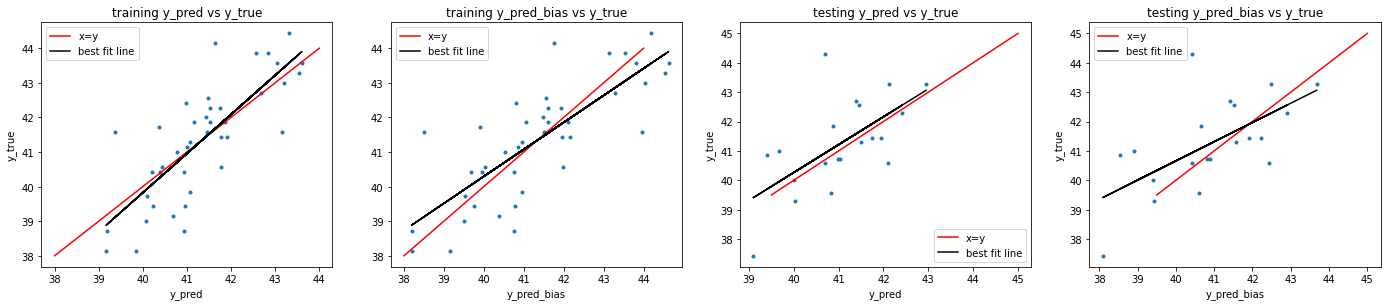

In [146]:
y_train_pred=pipe1.predict(X_trainval)
f,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4.5))
ax1.plot(y_train_pred,y_trainval,'.')
ax1.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred.reshape(-1,1),y_trainval)
ax1.plot(y_train_pred,lin_reg.predict(y_train_pred.reshape(-1,1)),'k-',label='best fit line')
ax1.set_ylabel('y_true')
ax1.set_xlabel('y_pred')
ax1.legend()
ax1.set_title('training y_pred vs y_true')

y_pred=pipe1.predict(X_test)
ax3.plot(y_pred,y_test,'.')
ax3.plot([39.5,45],[39.5,45],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred.reshape(-1,1),y_test)
ax3.plot(y_pred,lin_reg.predict(y_pred.reshape(-1,1)),'k-',label='best fit line')
ax3.set_ylabel('y_true')
ax3.set_xlabel('y_pred')
ax3.legend()
ax3.set_title('testing y_pred vs y_true')


lin_reg_bias=LinearRegression()
coef,inter=MLtraining.get_model_bias(y_trainval,y_train_pred)
y_train_pred_bias=y_train_pred+y_train_pred*coef+inter
ax2.plot(y_train_pred_bias,y_trainval,'.')
ax2.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred_bias.reshape(-1,1),y_trainval)
ax2.plot(y_train_pred_bias,lin_reg.predict(y_train_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax2.set_xlabel('y_pred_bias')
ax2.legend()
ax2.set_title('training y_pred_bias vs y_true')

y_pred_bias=y_pred+y_pred*coef+inter
ax4.plot(y_pred_bias,y_test,'.')
ax4.plot([39.5,45],[39.5,45],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred_bias.reshape(-1,1),y_test)
ax4.plot(y_pred_bias,lin_reg.predict(y_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax4.set_ylabel('y_true')
ax4.set_xlabel('y_pred_bias')
ax4.legend()
ax4.set_title('testing y_pred_bias vs y_true')



In [147]:
brain_age_difference=pd.DataFrame(y_high_risk_pred_dict)
brain_age_difference['mean_PMA_pred']=brain_age_difference.mean(axis=1)
brain_age_difference['true_PMA']=y_high_risk
brain_age_difference['residual']=brain_age_difference['mean_PMA_pred']-brain_age_difference['true_PMA']

brain_age_difference

,0,1,2,mean_PMA_pred,true_PMA,residual
0,41.240149,41.274992,41.685010,41.400050,43.571429,-2.171378
1,40.251331,40.409058,40.313188,40.324526,41.000000,-0.675474
2,41.836346,42.210084,43.323437,42.456622,42.714286,-0.257663
3,42.502855,43.162731,42.176902,42.614162,42.285714,0.328448
4,43.078911,44.895385,44.455007,44.143101,44.000000,0.143101
5,42.315409,42.295197,41.767739,42.126115,42.000000,0.126115
6,39.746525,39.561917,38.743244,39.350562,42.142857,-2.792295
7,43.077272,43.877348,43.620748,43.525123,44.285714,-0.760592
8,40.334341,40.446633,39.419668,40.066881,42.000000,-1.933119
9,41.371231,41.842180,40.576869,41.263427,42.428571,-1.165145


In [148]:
brain_age_difference_corr=pd.DataFrame({'Correlation':(pearsonr(brain_age_difference.loc[:,'residual'],adjusted_prs_score_scaled_high_risk))[0],
'p-value':(pearsonr(brain_age_difference.loc[:,'residual'],adjusted_prs_score_scaled_high_risk))[1]},index=['PRS_0.05'])

brain_age_difference_corr

,Correlation,p-value
PRS_0.05,-0.567886,0.001312


Text(0, 0.5, 'brain age difference')

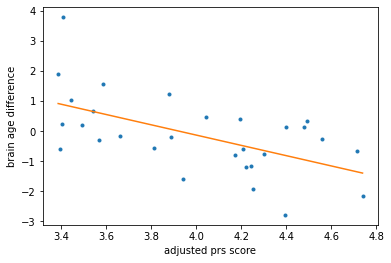

In [149]:
plt.plot(adjusted_prs_score_scaled_high_risk,brain_age_difference.loc[:,'residual'],'.')
lin_reg=LinearRegression()
lin_reg.fit(adjusted_prs_score_scaled_high_risk.reshape(-1,1),brain_age_difference.loc[:,'residual'].values)
plt.plot(adjusted_prs_score_scaled_high_risk,lin_reg.predict(adjusted_prs_score_scaled_high_risk.reshape(-1,1)))
plt.xlabel('adjusted prs score')
plt.ylabel('brain age difference')

### Checking features

In [163]:
original_ROIs_combinations=european_diffusion_dataset_term.loc[low_risk,"'1 Precentral_L 2001'":"'93 Vermis'"].columns
pipe0.named_steps['remove_zeros'].get_column_names(original_ROIs_combinations)
ROIs_combination_remove_zeros=pipe0.named_steps['remove_zeros'].reduced_features_names
print(ROIs_combination_remove_zeros.shape)

(93,)


In [164]:
inner_folds_selection=pd.DataFrame(inner_fold_feature_selection_logs)
inner_folds_selection=inner_folds_selection[(inner_folds_selection[0]==True)&(inner_folds_selection[1]==True)&(inner_folds_selection[2]==True)]

In [59]:
ROIs_coef=pd.DataFrame(zip(ROIs_combination_select_univariate,features_coefs_dict[0],features_coefs_dict[1],features_coefs_dict[2]),columns=['Region','Coef_split_1','Coef_split_2','Coef_split_3'])
ROIs_coef['Mean_Coef']=ROIs_coef[['Coef_split_1','Coef_split_2','Coef_split_3']].mean(axis=1)

In [60]:
ROIs_coef_RidgeCV_vol=ROIs_coef.reindex(ROIs_coef['Mean_Coef'].abs().sort_values(ascending=False).index)

In [61]:
ROIs_coef_RidgeCV_vol

,Region,Coef_split_1,Coef_split_2,Coef_split_3,Mean_Coef
5,'16 Frontal_Inf_Orb_R 2322',0.446644,0.403308,0.959666,0.603206
10,'30 Insula_R 3002',-0.572177,-0.286484,-0.781864,-0.546841
7,'20 Supp_Motor_Area_R 2402',0.695630,0.332741,0.415980,0.481450
2,'5 Frontal_Sup_Orb_L 2111',-0.521831,-0.394103,-0.315553,-0.410496
13,'34 Cingulum_Mid_R 4012',0.507007,0.181466,0.515384,0.401286
11,'31 Cingulum_Ant_L 4001',0.324469,0.277200,0.248495,0.283388
18,'63 SupraMarginal_L 6211',0.470864,0.292409,0.025521,0.262932
21,'74 Putamen_R 7012',0.395553,-0.054899,0.187527,0.176060
9,'24 Frontal_Sup_Medial_R 2602',0.333278,0.110334,0.051903,0.165172
23,'81 Temporal_Sup_L 8111',0.289218,0.102498,0.091448,0.161055


In [62]:
merged_feature_dict_strings_vol=pipe0.named_steps['remove_correlation'].merged_feature_dict_strings

## Random Forest

In [63]:
#Training the PMA prediction model on the transformed low_risk dataset
data_splitting=MLtraining.splitting_dataset_into_k_fold(X_low_risk_after_pipe0,y_low_risk,k=3)
result={}
y_high_risk_pred_dict={}
features_coefs_dict={}
for i in tqdm.tqdm(range(3)):
    X_trainval, y_trainval, X_test, y_test=next(data_splitting)
    inner_cv=KFold(n_splits=3)
    # regr=RidgeCV(cv=inner_cv)#find the best_hyperparameter
    # regr=RandomForestRegressor(n_estimators=30,max_depth=250,bootstrap=True,oob_score=False,random_state=42)
    regr=RandomForestRegressor(bootstrap=True,oob_score=False,random_state=42)
    param_dict=[{'regr__n_estimators':[30,150],'regr__max_depth':[250]}]
    pipe1=Pipeline([('scaler', MinMaxScaler()),('regr',regr)])
    search=GridSearchCV(pipe1,param_grid=param_dict,cv=inner_cv).fit(X_trainval,y_trainval).fit(X_trainval,y_trainval)
    pipe1=search.best_estimator_
    print(pipe1)

    bias_coeff,bias_intercept=MLtraining.get_model_bias(y_trainval,pipe1.predict(X_trainval))
    y_pred=pipe1.predict(X_test)#model performance on low risk
    y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    result[i]=MLtraining.print_scores(y_pred,y_test)
    features_coefs_dict[i]=pipe1.named_steps['regr'].feature_importances_

    #use the trained model to predict the brain age (PMA at scan) for high risk subject
    y_high_risk_pred=pipe1.predict(X_high_risk_after_pipe0)
    y_high_risk_pred=y_high_risk_pred+y_high_risk_pred*bias_coeff+bias_intercept
    y_high_risk_pred_dict[i]=y_high_risk_pred

 33%|███▎      | 1/3 [00:01<00:03,  1.91s/it]Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regr',
                 RandomForestRegressor(max_depth=250, n_estimators=150,
                                       random_state=42))])
 67%|██████▋   | 2/3 [00:03<00:01,  1.85s/it]Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regr',
                 RandomForestRegressor(max_depth=250, n_estimators=30,
                                       random_state=42))])
100%|██████████| 3/3 [00:05<00:00,  1.92s/it]Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regr',
                 RandomForestRegressor(max_depth=250, n_estimators=30,
                                       random_state=42))])



In [64]:
PMA_result=pd.DataFrame(result).T
PMA_result=PMA_result.append(pd.DataFrame(PMA_result.mean(axis=0)).T,ignore_index=True)
PMA_result.rename(index={0:'0',1:'1',2:'2',3:'Average'})

,r2,MAE,MSE,Correlation,p_value
0,0.335387,0.919597,1.426724,0.617492,0.002859
1,0.477279,1.040926,1.588431,0.726287,0.000288
2,0.422627,1.018265,1.369905,0.685205,0.000856
Average,0.411764,0.992929,1.461687,0.676328,0.001334


Text(0.5, 1.0, 'testing y_pred_bias vs y_true')

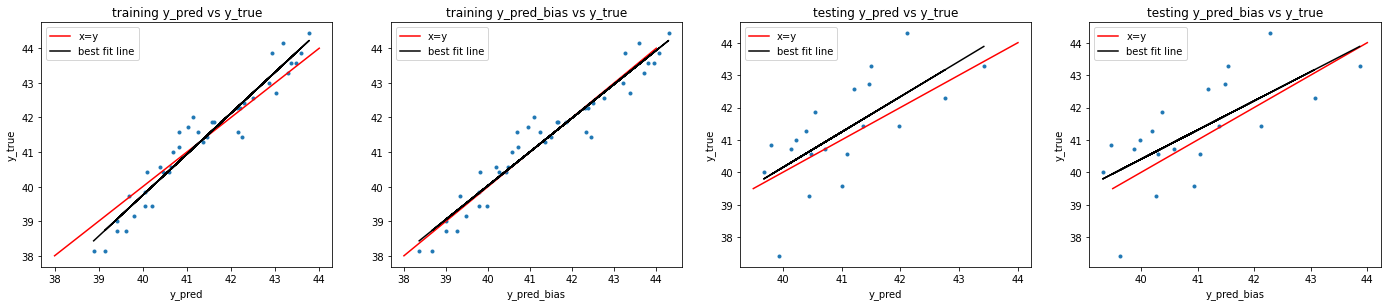

In [65]:
y_train_pred=pipe1.predict(X_trainval)
f,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4.5))
ax1.plot(y_train_pred,y_trainval,'.')
ax1.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred.reshape(-1,1),y_trainval)
ax1.plot(y_train_pred,lin_reg.predict(y_train_pred.reshape(-1,1)),'k-',label='best fit line')
ax1.set_ylabel('y_true')
ax1.set_xlabel('y_pred')
ax1.legend()
ax1.set_title('training y_pred vs y_true')

y_pred=pipe1.predict(X_test)
ax3.plot(y_pred,y_test,'.')
ax3.plot([39.5,44],[39.5,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred.reshape(-1,1),y_test)
ax3.plot(y_pred,lin_reg.predict(y_pred.reshape(-1,1)),'k-',label='best fit line')
ax3.set_ylabel('y_true')
ax3.set_xlabel('y_pred')
ax3.legend()
ax3.set_title('testing y_pred vs y_true')


lin_reg_bias=LinearRegression()
coef,inter=MLtraining.get_model_bias(y_trainval,y_train_pred)
y_train_pred_bias=y_train_pred+y_train_pred*coef+inter
ax2.plot(y_train_pred_bias,y_trainval,'.')
ax2.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred_bias.reshape(-1,1),y_trainval)
ax2.plot(y_train_pred_bias,lin_reg.predict(y_train_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax2.set_xlabel('y_pred_bias')
ax2.legend()
ax2.set_title('training y_pred_bias vs y_true')

y_pred_bias=y_pred+y_pred*coef+inter
ax4.plot(y_pred_bias,y_test,'.')
ax4.plot([39.5,44],[39.5,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred_bias.reshape(-1,1),y_test)
ax4.plot(y_pred_bias,lin_reg.predict(y_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax4.set_ylabel('y_true')
ax4.set_xlabel('y_pred_bias')
ax4.legend()
ax4.set_title('testing y_pred_bias vs y_true')



In [66]:
brain_age_difference=pd.DataFrame(y_high_risk_pred_dict)
brain_age_difference['mean_PMA_pred']=brain_age_difference.mean(axis=1)
brain_age_difference['true_PMA']=y_high_risk
brain_age_difference['residual']=brain_age_difference['mean_PMA_pred']-brain_age_difference['true_PMA']

In [67]:
brain_age_difference_corr=pd.DataFrame({'Correlation':(pearsonr(brain_age_difference['residual'],adjusted_prs_score[high_risk]))[0],
'p-value':(pearsonr(brain_age_difference['residual'],adjusted_prs_score[high_risk]))[1]},index=['PRS_0.05'])

brain_age_difference_corr

,Correlation,p-value
PRS_0.05,-0.488728,0.005274


Text(0, 0.5, 'brain age difference')

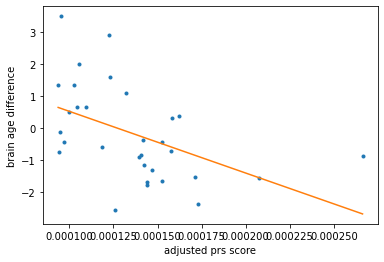

In [81]:
plt.plot(adjusted_prs_score[high_risk],brain_age_difference['residual'],'.')
lin_reg=LinearRegression()
lin_reg.fit(adjusted_prs_score[high_risk].reshape(-1,1),brain_age_difference['residual'].values)
plt.plot(adjusted_prs_score[high_risk],lin_reg.predict(adjusted_prs_score[high_risk].reshape(-1,1)))
plt.xlabel('adjusted prs score')
plt.ylabel('brain age difference')

In [68]:
ROIs_coef=pd.DataFrame(zip(ROIs_combination_select_univariate,features_coefs_dict[0],features_coefs_dict[1],features_coefs_dict[2]),columns=['Region','Coef_split_1','Coef_split_2','Coef_split_3'])
ROIs_coef['Mean_Coef']=ROIs_coef[['Coef_split_1','Coef_split_2','Coef_split_3']].mean(axis=1)

In [69]:
ROIs_coef_RF_vol=ROIs_coef.sort_values(by='Mean_Coef',ascending=False)

In [70]:
ROIs_coef_RF_vol

,Region,Coef_split_1,Coef_split_2,Coef_split_3,Mean_Coef
5,'16 Frontal_Inf_Orb_R 2322',0.023498,0.177345,0.343505,0.181449
18,'63 SupraMarginal_L 6211',0.171042,0.162754,0.035974,0.123257
7,'20 Supp_Motor_Area_R 2402',0.224439,0.083770,0.054881,0.121030
11,'31 Cingulum_Ant_L 4001',0.136290,0.064065,0.028233,0.076196
19,'67 Precuneus_L 6301',0.049740,0.056209,0.087336,0.064428
14,'54 Occipital_Inf_R 5302',0.018155,0.060273,0.071823,0.050084
0,'1 Precentral_L 2001',0.017492,0.077831,0.029671,0.041664
13,'34 Cingulum_Mid_R 4012',0.024939,0.001843,0.066005,0.030929
25,'90 Temporal_Inf_R 8302',0.012046,0.031471,0.041095,0.028204
6,'18 Rolandic_Oper_R 2332',0.018668,0.042126,0.021870,0.027554


In [97]:
combined_best_ROIs_coef_table=ROIs_coef_RidgeCV_vol.head(10).merge(ROIs_coef_RF_vol.head(10),on='Region',suffixes=('_RidgeCV','_RF'),how='outer',indicator=True)
combined_best_ROIs_coef_table['Merged_Feature']=[False if not merged_feature_dict_strings_vol[i] else True for i in combined_best_ROIs_coef_table['Region']]

In [98]:
combined_best_ROIs_coef_table.drop(columns=combined_best_ROIs_coef_table.columns[[1,2,3,5,6,7]])

,Region,Mean_Coef_RidgeCV,Mean_Coef_RF,_merge,Merged_Feature
0,'16 Frontal_Inf_Orb_R 2322',0.603206,0.181449,both,True
1,'30 Insula_R 3002',-0.546841,NaN,left_only,True
2,'20 Supp_Motor_Area_R 2402',0.481450,0.121030,both,False
3,'5 Frontal_Sup_Orb_L 2111',-0.410496,NaN,left_only,False
4,'34 Cingulum_Mid_R 4012',0.401286,0.030929,both,True
5,'31 Cingulum_Ant_L 4001',0.283388,0.076196,both,False
6,'63 SupraMarginal_L 6211',0.262932,0.123257,both,False
7,'74 Putamen_R 7012',0.176060,NaN,left_only,True
8,'24 Frontal_Sup_Medial_R 2602',0.165172,NaN,left_only,False
9,'81 Temporal_Sup_L 8111',0.161055,NaN,left_only,False


In [99]:
merged_feature_dict_strings_vol["'67 Precuneus_L 6301'"]

["'67 Precuneus_L 6301'", "'68 Precuneus_R 6302'"]

# With sparsePCA

Issues with sPCA: https://github.com/scikit-learn/scikit-learn/issues/13127 it is not similar to R package

In [42]:
#Perform Retain_non_zero_features, and correlated features to prs_score from the low_risk dataset
start=time.time()
pipe0=Pipeline([('remove_zeros',MLtraining.Retain_non_zero_features()),
('remove_correlation',MLtraining.High_Corr_Remover(target=adjusted_prs_score[low_risk],thresh=0.8,average=True)),
('select_p_Val',MLtraining.Select_Features_Multivariate(adjusted_prs_score[low_risk],covariates[low_risk,:])),
('scaler',StandardScaler()),
('sPCA',SparsePCA(random_state=42))])
X_low_risk_after_pipe0=pipe0.fit_transform(X_low_risk)
X_high_risk_after_pipe0=pipe0.transform(X_high_risk)
print(time.time()-start)

64.75750494003296


In [53]:
np.unique(pipe0.named_steps['sPCA'].components_,return_index=True)

(array([-1.        , -0.99976632, -0.98102738, -0.19386923, -0.02161742,
         0.        ,  0.02345787,  0.23964835,  0.51421579,  0.85766085,
         0.97085976,  0.99972483,  1.        ]),
 array([  189, 28120, 21021, 21011, 27953,     0,  2143, 20655, 12111,
        12105, 20726,  2144,   176]))

In [ ]:
#Training the PMA prediction model on the transformed low_risk dataset
data_splitting=MLtraining.splitting_dataset_into_k_fold(X_low_risk_after_pipe0,y_low_risk,k=3)
result={}
y_high_risk_pred_dict={}
features_coefs_dict={}
for i in tqdm.tqdm(range(3)):
    X_trainval, y_trainval, X_test, y_test=next(data_splitting)
    inner_cv=KFold(n_splits=3)
    regr=RidgeCV(cv=inner_cv)#find the best_hyperparameter
    # pipe1=Pipeline([('scaler', StandardScaler()),('regr',regr)])
    pipe1=Pipeline([('regr',regr)])
    pipe1.fit(X_trainval,y_trainval)
    bias_coeff,bias_intercept=MLtraining.get_model_bias(y_trainval,pipe1.predict(X_trainval))
    y_pred=pipe1.predict(X_test)#model performance on low risk
    y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    result[i]=MLtraining.print_scores(y_pred,y_test)
    features_coefs_dict[i]=pipe1.named_steps['regr'].coef_

    #use the trained model to predict the brain age (PMA at scan) for high risk subject
    y_high_risk_pred=pipe1.predict(X_high_risk_after_pipe0)
    y_high_risk_pred=y_high_risk_pred+y_high_risk_pred*bias_coeff+bias_intercept
    y_high_risk_pred_dict[i]=y_high_risk_pred
PMA_result=pd.DataFrame(result).T
PMA_result=PMA_result.append(pd.DataFrame(PMA_result.mean(axis=0)).T,ignore_index=True)
PMA_result.rename(index={0:'0',1:'1',2:'2',3:'Average'})


brain_age_difference_corr=pd.DataFrame({'Correlation':(pearsonr(brain_age_difference['residual'],adjusted_prs_score[high_risk]))[0],
'p-value':(pearsonr(brain_age_difference['residual'],adjusted_prs_score[high_risk]))[1]},index=['PRS_0.05'])

brain_age_difference_corr


#Checking features
original_ROIs_combinations=european_diffusion_dataset_term.loc[low_risk,'PreCG.R_PreCG.L':'ITG.R_ITG.L'].columns
pipe0.named_steps['remove_zeros'].get_column_names(original_ROIs_combinations)
ROIs_combination_remove_zeros=pipe0.named_steps['remove_zeros'].reduced_features_names
print(ROIs_combination_remove_zeros.shape)
pipe0.named_steps['remove_correlation'].get_column_names(ROIs_combination_remove_zeros)
ROIs_combination_remove_correlation=pipe0.named_steps['remove_correlation'].reduced_features_names
print(ROIs_combination_remove_correlation.shape)
pipe0.named_steps['select_univariate'].get_column_names(ROIs_combination_remove_correlation)
ROIs_combination_select_univariate=pipe0.named_steps['select_univariate'].reduced_features_names
print(ROIs_combination_select_univariate.shape)


pca_list=['PC_'+str(i) for i in range(ROIs_combination_select_univariate.shape[0])]

ROIs_coef=pd.DataFrame(zip(pca_list,features_coefs_dict[0],features_coefs_dict[1],features_coefs_dict[2]),columns=['Connection','Coef_split_1','Coef_split_2','Coef_split_3'])
ROIs_coef['Mean_Coef']=ROIs_coef[['Coef_split_1','Coef_split_2','Coef_split_3']].mean(axis=1)



ROIs_coef.set_index('Connection').sort_values('Mean_Coef')


ROIs_combination_select_univariate[pipe0.named_steps['sPCA'].components_[:,109]!=0]


pipe0.named_steps['sPCA'].components_[:,109]

In [ ]:
#Perform Retain_non_zero_features, and correlated features to prs_score from the low_risk dataset
start=time.time()
pipe0=Pipeline([('remove_zeros',MLtraining.Retain_non_zero_features()),
('remove_correlation',MLtraining.High_Corr_Remover(target=adjusted_prs_score[low_risk],thresh=0.85,average=True)),
('select_p_Val',MLtraining.Select_Features_Multivariate(target=adjusted_prs_score[low_risk],covariates=covariates[low_risk,:],p_value_threshold=0.05))])
X_low_risk_after_pipe0=pipe0.fit_transform(X_low_risk)
X_high_risk_after_pipe0=pipe0.transform(X_high_risk)
print(time.time()-start)

multivariate

In [5]:
# Performing univariate tests and NBS

In [6]:
import statsmodels.api as sm

In [7]:
european_diffusion_dataset_term=pd.read_csv('./preprocessed_data/diffusion/term/european_diffusion_dataset_term.csv')

In [8]:
X_total=np.asarray(european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'])
feature_column_names=european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'].columns

In [33]:
retain_non_zero=MLtraining.Retain_non_zero_features().fit(X_total)
X_total[:,retain_non_zero.zero_perc>0]=np.nan # keep the 4005 features, but set the  sparse ones to np.nan

In [10]:
covariates=np.asarray(european_diffusion_dataset_term[['GA_diff','PMA_diff','Gender','Anc_PC1','Anc_PC2','Anc_PC3']])
target=np.asarray(european_diffusion_dataset_term['PRS_0.05'])

In [11]:
observed_data=MLtraining.Select_Features_Multivariate(target=target,covariates=covariates).fit(X_total)

74

In [21]:
#the lowest p-value from the observed data is
np.min(observed_data.p_value[~np.isnan(observed_data.p_value)])

0.0003581546241584331

# the component size of the observed data is
observed_data.return_largest_component_size()

In [85]:
Using NBS

100%|██████████| 2/2 [00:05<00:00,  2.52s/it]


In [88]:
NBS_result=np.loadtxt('./log/diffusion/term/NBS_results.txt')

In [91]:
permutation_prs_p_val_null_distribution=NBS_result[:,0]
permutation_NBS_p_val_null_distribution=NBS_result[:,1]

In [98]:
len(np.where(permutation_prs_p_val_null_distribution<=0.0003581546241584331
)[0])/5000

0.47

In [102]:
len(np.where(permutation_NBS_p_val_null_distribution>=74)[0])/5000

0.4858

Our p-value did not survive the multi correction tests.

In [135]:
from sklearn.decomposition import PCA
pca=PCA()

X_total=np.asarray(european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'])
feature_column_names=european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'].columns

retain_non_zero=MLtraining.Retain_non_zero_features().fit(X_total)
X_total_reduced=retain_non_zero.transform(X_total)
retain_non_zero.get_column_names(feature_column_names)

Retain_non_zero_features()

In [136]:
X_total_reduced_pca=pca.fit_transform(StandardScaler().fit_transform(X_total_reduced))

In [137]:
import statsmodels.api as sm
from collections import defaultdict
model_pval=defaultdict(list)
covariates=np.asarray(european_diffusion_dataset_term[['GA_diff','PMA_diff','Gender','Anc_PC1','Anc_PC2','Anc_PC3']])
target=np.asarray(european_diffusion_dataset_term['PRS_0.05'])
independent_Var=np.concatenate((covariates,target.reshape(-1,1)),axis=1)
independent_Var=sm.add_constant(independent_Var)
for col in range(X_total_reduced_pca.shape[1]):
    model=sm.OLS(X_total_reduced_pca[:,col],independent_Var).fit()
    model_pval[col]=model.pvalues

In [138]:
diffusion_pca_pval=pd.DataFrame(model_pval).T
diffusion_pca_pval.columns=['const_pval','GA_diff_pval','PMA_diff_pval','Gender_pval','Anc_PC1_pval','Anc_PC2_pval','Anc_PC3_pval','prs_pval']

In [140]:
diffusion_pca_pval.loc[0,:]

const_pval       2.872769e-14
GA_diff_pval     5.724765e-01
PMA_diff_pval    6.785081e-20
Gender_pval      5.536841e-03
Anc_PC1_pval     7.830099e-01
Anc_PC2_pval     9.693142e-01
Anc_PC3_pval     2.021894e-01
prs_pval         4.058163e-02
Name: 0, dtype: float64

Only the first PCA is statistically significant. But it explains only 8% of the total variance.

Text(0.5, 0, 'PCs')

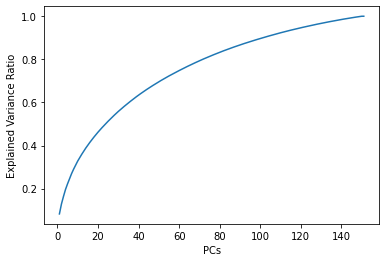

In [141]:
plt.plot(np.arange(1,X_total_reduced_pca.shape[1]+1),np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Explained Variance Ratio')
plt.xlabel('PCs')

In [153]:
np.argsort(np.abs(pca.components_[0]))[::-1]
np.sort(np.abs(pca.components_[0]))[::-1]

array([5.20531235e-02, 5.18096252e-02, 5.13425734e-02, ...,
       9.36631837e-06, 5.07824704e-06, 2.85355542e-06])

In [154]:
retain_non_zero.reduced_features_names[np.argsort(np.abs(pca.components_[0]))[::-1]][:10]

Index(['ROL.L_IFGoperc.L', 'PUT.L_INS.L', 'TPOsup.R_SPG.R', 'PUT.R_INS.R',
       'SPG.R_ORBinf.R', 'TPOsup.R_SMG.R', 'SPG.R_ORBmid.R', 'TPOsup.L_PoCG.L',
       'PreCUN.L_SPG.L', 'ORBinf.R_IFGtriang.R'],
      dtype='object')

In [19]:
high_risk_corr_matrix=np.corrcoef(X_high_risk,rowvar=False)
low_risk_corr_matrix=np.corrcoef(X_low_risk,rowvar=False)

In [20]:
from sklearn.preprocessing import StandardScaler
high_risk_corr_matrix=StandardScaler().fit_transform(high_risk_corr_matrix)
low_risk_corr_matrix=StandardScaler().fit_transform(low_risk_corr_matrix)

high_risk_corr_matrix=graph_analysis.binarize_matrix_based_on_sparsity_threshold(abs(high_risk_corr_matrix),0.10)
low_risk_corr_matrix=graph_analysis.binarize_matrix_based_on_sparsity_threshold(abs(low_risk_corr_matrix),0.10)

In [21]:
np.savetxt('./preprocessed_data/volumetric/term/high_risk_corr_matrix_vol.txt',high_risk_corr_matrix)
np.savetxt('./preprocessed_data/volumetric/term/low_risk_corr_matrix_vol.txt',low_risk_corr_matrix)

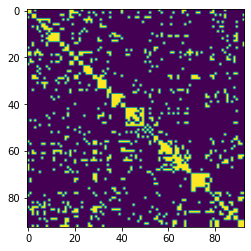

In [9]:
plt.imshow(low_risk_corr_matrix)

In [13]:
def clustering_coefficient_and_path_length(G):
    clustering_values=graph_analysis.clustering(G)
    clustering_values=np.mean([abs(value) for value in clustering_values.values()])
    path_length=[]
    for C in (G.subgraph(c).copy() for c in nx.connected_components(G)):
        path_length.append(graph_analysis.average_shortest_path_length(C))
    path_length=np.mean(path_length)
    return clustering_values,path_length

In [10]:
import bct

In [16]:
np.mean(bct.algorithms.clustering_coef_bu(low_risk_corr_matrix))

0.4998739332675239

In [52]:
test2=np.triu(low_risk_corr_matrix)

In [53]:
test2

array([[1., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

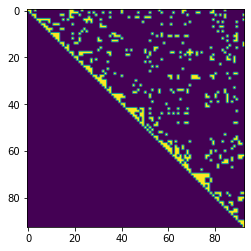

In [54]:
plt.imshow(test2)

In [14]:
import networkx as nx

In [55]:
bct.density_und(test2)

(0.1402524544179523, 93, 600)

In [34]:
600/(93*93)

0.0693721817551162

In [25]:
?bct.algorithms.distance.distance_bin

Signature: bct.algorithms.distance.distance_bin(G)
Docstring:
The distance matrix contains lengths of shortest paths between all
pairs of nodes. An entry (u,v) represents the length of shortest path
from node u to node v. The average shortest path length is the
characteristic path length of the network.

Parameters
----------
A : NxN np.ndarray
    binary directed/undirected connection matrix

Returns
-------
D : NxN
    distance matrix

Notes
-----
Lengths between disconnected nodes are set to Inf.
Lengths on the main diagonal are set to 0.
Algorithm: Algebraic shortest paths.
File:      ~/src/bctpy/bct/algorithms/distance.py
Type:      function


In [145]:
test=(bct.algorithms.makerandCIJ_und(93,600))

In [146]:
test=np.maximum(test,test.T)

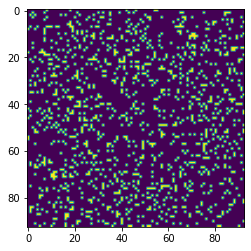

In [155]:
plt.imshow(bct.randomizer_bin_und(test,1))